# GJR-GARCH(1,1) process with unconditional mean and skewed-t errors
## 1. Data simulation
In this section, we generate our true data according to the following data generating process: a GJR-GARCH(1,1) for the conditional variance, unconditional mean and skewed-t errors. Formally, we assume that return of asset $i$ at day $t$ is given by 
\begin{eqnarray} 
r_{i,t} &=& \mu_i + \sigma_{i,t} z_{i,t}
\label{equation:return} \\ 
\sigma_{i,t}^2 &=&  \omega_i + \beta_i  \sigma_{i,t-1}^2 + \alpha_i (\sigma_{i,t-1} z_{i,t-1})^2 + \gamma (\sigma_{i,t-1} z_{i,t-1})^2 I_{\{z_{i,t-1}<0\}} \label{equation:conditionalvariance}  
\end{eqnarray} where  
- $z_{i,t}$ is an i.i.d. random variable that follows a skewed-t of Hansen (1994) distribution, with degrees of freedom and asymmetry parameters  denoted by $2<\nu_i<\infty$ and $-1<\lambda_i<1$, respectively.
- $\mu_i$ denotes de unconditional mean.
- $\sigma_{i,t}^2$ corresponds to the conditional variance which describes a GJR-GARCH model
- $I$ is an indicator function that takes the value of 1 if the inequality is satisfied and 0 otherwise.
- Positiveness restrictions: $\omega_i>0$, $\alpha_i\geq 0$, $\alpha_i+\gamma_i>0$ and $\beta_i\geq 0$ 
- Stationarity restriction:  $\alpha_i+\frac{1}{2}\gamma_i+\beta_i<1$

The set of model parameters is $\theta_i=(\mu_i, \omega_i, \beta_i, \alpha_i, \gamma_i,\nu_i,\lambda_i)$.

The following helper function named **skewtinv** computes the inverse of a skewed-t cumulative distribution function, e.g., it computes $z = F^{-1}(p|\nu,\lambda)$, where $p$ denotes a cumulative probability and $\nu$, $\lambda$ are shape parameters that controls for kurtosis and skewness, respectively. 

In [20]:
skewtinv <- function(p, nu, lambda) {
# USAGE:
#   X=skewtinv(P,V,LAMBDA)
 
# INPUTS:
#   P      - Values to be inverted, P in [0,1]
#   nu     - kurtosis parameter
#   lambda - skewness parameter 
     
# OUTPUTS:
#   X      - Skewed T distributed random variables corresponding to P

# COMMENTS:
#   nu > 2
#   -.99 < lambda < .99  
    
# REFERENCE:
#   [1] Hansen (1994), Intl.Econ.Rev. (35)

c <- gamma((nu+1)/2)/(sqrt(pi*(nu-2))*gamma(nu/2))
a <- 4*lambda*c*((nu-2)/(nu-1))
b <- sqrt(1 + 3*lambda^2 - a^2)
  
f1 <- which(p <  (1-lambda)/2)
f2 <- which(p >= (1-lambda)/2)

inv1 <- ((1-lambda)/b)*sqrt((nu-2)/nu)*qt(p[f1]/(1-lambda),nu) - a/b
inv2 <- ((1+lambda)/b)*sqrt((nu-2)/nu)*qt(0.5+1/(1+lambda)*(p[f2]-(1-lambda)/2),nu) - a/b

x <- rep(NaN,length(p))
x[f1] <- inv1
x[f2] <- inv2
return(x) 
}

In [21]:
set.seed(12345) # for reproducibility
T <- 4000 # Number of simulated data
burn <- 200 # we drop first observations
TT <- T + burn

# Paramteres:
# inverse leverage effect:
# mu <- 0.07; omega <- 0.03; beta <- 0.8; alpha <- 0.2; gamma <- -0.08; nu <- 3.5; lambda <- -0.1;
# leverage effect:
mu <- 0.07; omega <- 0.03; beta <- 0.94; alpha <- 0.02; gamma <- 0.08; nu <- 3.5; lambda <- -0.1;
 
# generate TT random variables, uniformly distributed between 0 and 1:
Fdata <- runif(TT, min = 0.0001, max = 0.9999)

# obtain standardized returns, recall that Z ~ F(z|nu,lambda) where F is a skewed-t CDF:
z <- skewtinv(Fdata,nu,lambda)

# we will store the simulated conditional variance, returns and prices series here:
sigma2 <- replicate(TT,0)
ret <- replicate(TT,0)
price <- replicate(TT,0)

# initial values (required to start the process):
sigma2[1] <- omega
ret[1] = mu + z[1]*sqrt(sigma2[1])
price[1] = 10 # arbitrary

for (t in 2 : TT)  {
      sigma2[t] <-  omega + beta*sigma2[t-1] + alpha*(z[t-1]*sqrt(sigma2[t-1]))^2 + gamma*min((z[t-1]*sqrt(sigma2[t-1])),0)^2 # GJR-GARCH(1,1) 
      ret[t] = mu + z[t]*sqrt(sigma2[t])
      price[t] = price[t-1]*(1+ret[t]/100)
    }

date <- seq(as.Date("2000-01-01"),as.Date("2019-12-31"),by = 1)

# drop first observations (usually, first observations are not good):
truedf <- data.frame("date" = tail(date,T), "p" = tail(price,T),"r" = tail(ret,T), "z" = tail(z,T))

Let's take a look to the last observations of our simulated dataset:

In [22]:
tail(truedf)

,date,p,r,z
,<date>,<dbl>,<dbl>,<dbl>
3995,2019-12-26,147.7466,-0.03406161,-0.04759810
3996,2019-12-27,144.3724,-2.28376900,-1.10662855
3997,2019-12-28,144.4247,0.03616307,-0.01538584
3998,2019-12-29,145.0998,0.46746955,0.18579603
3999,2019-12-30,149.2523,2.86182806,1.34088007
4000,2019-12-31,144.9063,-2.91185642,-1.44456758


Some descriptive statistics of our simulated data:

In [23]:
summary(truedf[,-1]) 

       p                r                   z            
 Min.   : 14.58   Min.   :-17.69707   Min.   :-7.264076  
 1st Qu.: 42.81   1st Qu.: -0.70708   1st Qu.:-0.461484  
 Median :114.17   Median :  0.16556   Median : 0.059886  
 Mean   :100.66   Mean   :  0.07393   Mean   :-0.005174  
 3rd Qu.:137.45   3rd Qu.:  0.95114   3rd Qu.: 0.515237  
 Max.   :209.27   Max.   : 12.88380   Max.   : 6.152402  

Data visualization:

In [24]:
# libraries for visualization
library(ggplot2)
library(ggpubr)

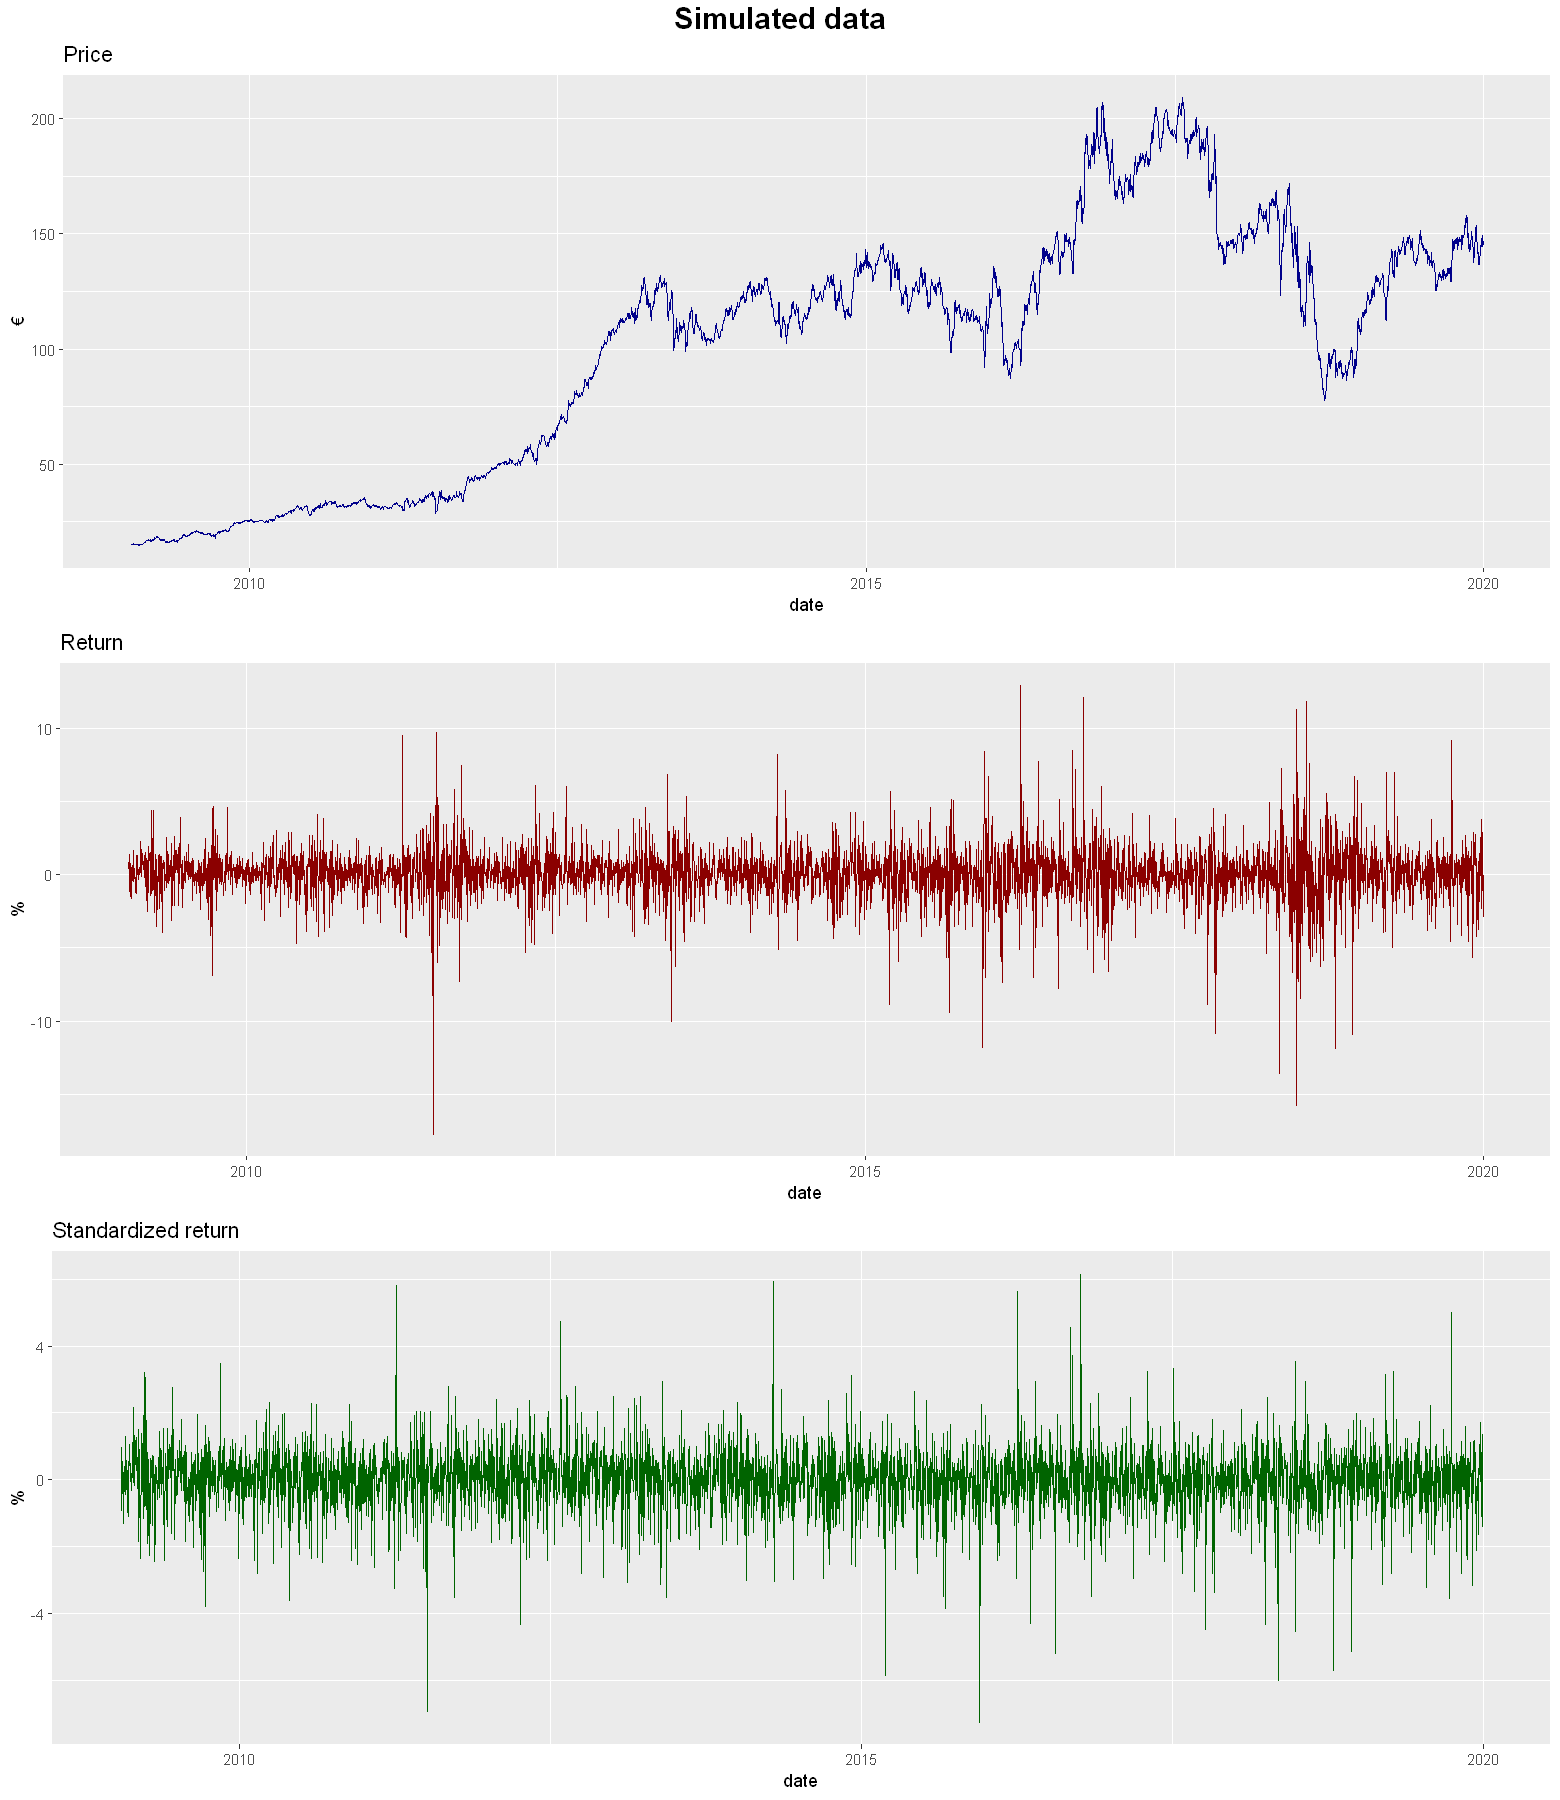

In [25]:
pplot <- ggplot(truedf, aes(x = date)) + 
  geom_line(aes(y = p), size = 0.3, color = "darkblue") +
  labs(title = "Price", 
    #subtitle = print("Total sample"),
    x = "date",
    y = "€" )

rplot <- ggplot(truedf, aes(x = date)) + 
  geom_line(aes(y = r), size = 0.3, color = "darkred") +
  labs(title = "Return", 
    x = "date",
    y = "%" )

zplot <- ggplot(truedf, aes(x = date)) + 
  geom_line(aes(y = z), size = 0.3, color = "darkgreen") +
  labs(title = "Standardized return", 
    #subtitle = print("Total sample"),
    x = "date",
    y = "%" )

options(repr.plot.width=13, repr.plot.height=15)
figure <- ggarrange(pplot, rplot, zplot, 
                    ncol = 1, nrow = 3)

annotate_figure(figure, top = text_grob("Simulated data", color = "black", face = "bold", size = 18))  

## 2. Maximum likelihood estimation
Next, we estimate the parameters of the model by maximum likelihood (ML). The ML estimator of $\theta$ is given by $$\hat{\theta} = \arg \max_{\theta}(L_{z}(\theta))= \arg \max_{\theta} \sum_{t=1}^{T}\log(f(z_{t})),$$ where $f$ denotes the skewed-t density function of Hansen (1994).

The following helper function called **GJRloglik** computes $L_{z}(\theta)$. So that, our goal is to find the parameter set that maximizes the value of GJRloglik, given our data.

In [26]:
GJRloglik <- function(par, ret) {
    # Mean: unconditional mean 
    # Errors distribution: skewed-t (Hansen, 1994)  
    TT <- length(ret)
    
    # Starting values:
    rbar <- mean(ret)
    condVar <- matrix(rep(0,TT),TT)
    epsi <- matrix(rep(0,TT),TT)
    z <- matrix(rep(0,TT),TT)
    condVar[1] <- mean((ret-rbar)^2)
    epsi[1] <- sqrt(condVar[1])
    z[1] <- 0
  
    # Unconditional mean:
    mu <- par[1]
  
    # Conditional variance:
    # sigma_{t}^2 = omega + beta*sigma_{t-1}^2 + alpha*epsilon_{t-1}^2 + gamma*epsilon{t-1}^2*ind{z_{t-1}<0}
    b0 <- par[2] # omega
    b1 <- par[3] # beta
    b2 <- par[4] # alpha
    b3 <- par[5] # gamma
    
    # GJR-GARCH(1,1) :
    for (t in 2 : TT)  {
      condVar[t] <-  b0 + b1*condVar[t-1] + b2*epsi[t-1]^2 + b3*min(epsi[t-1],0)^2 # GJR-GARCH(1,1) 
      z[t] <- (ret[t]-mu)/sqrt(condVar[t])   
      epsi[t] <- z[t]*sqrt(condVar[t]) 
    }
    sigmaPrime <- sqrt( b0 + b1*tail(condVar,1) + b2*tail(epsi,1)^2 + b3*min(tail(epsi,1),0)^2 )
    
    # Distribution parameters:
    a <- tail(par,2) 
    nu <- a[1] # degrees of freedom
    lambda <- a[2] # skewnes parameter
   
  
    # Log-likelihood
    logc <- lgamma((nu+1)/2) - lgamma(nu/2) - log(sqrt(pi*(nu-2))) 
    c = exp(logc) 
    a <- 4*lambda*c*((nu-2)/(nu-1))
    logb <- 0.5*log(1 + 3*lambda^2 - a^2)
    b <- exp(logb)
    f1 <- which(z <  (-a/b))
    f2 <- which(z >= (-a/b))
    ll <- rep(NaN,length(z))
    ll1 <- logb + logc - ((nu+1)/2)*log(1 + (1/(nu-2))*((b*z[f1]+a)/(1-lambda))^2 ) - 0.5*log(condVar[f1])
    ll2 <- logb + logc - ((nu+1)/2)*log(1 + (1/(nu-2))*((b*z[f2]+a)/(1+lambda))^2 ) - 0.5*log(condVar[f2])
    ll[f1] <- ll1
    ll[f2] <- ll2 
    LL <- -(sum(ll[2:length(ll)]))
    
  return(LL)
}

Estimation:

In [27]:
# required library
library(pracma)

In [28]:
# Initial values
mu0 <- mean(truedf$r)
omega0 <- 0.01 ; beta0 <- 0.9 ; alpha0 <- 0.01 ; gamma0 <- 0.01
nu0 <- 4 ; lambda0 <- - 0.2
par0 <- c(mu0, omega0, beta0, alpha0, gamma0, nu0, lambda0) 

# Model restrictions
lb <- c(-100, rep(0.0001,3), -10, 2.01, -0.999) # lower bounds for GJR-GARCH(1,1) parameters: [mu, omega(>0), beta(>0), alpha(>0), gamma, nu(>2), lambda > -0.99]
ub <- c(rep(100,6), 0.999)                     # upper bounds for GJR-GARCH(1,1) parameters: [mu, omega, beta, alpha, gamma, nu, lambda < 0.99]
A  <- matrix(rbind(c(0, 0, 1, 1, 0.5, 0, 0), c(0, 0, 0, -1, -1, 0, 0)), 2)   # alpha + beta + 0.5*gamma < 1 and alpha + gamma > 0
b  <- matrix(c(0.999, -0.001),2)    
Aeq  <- NULL
beq  <- NULL
x1 <- fmincon(x0 = par0, 
            ret = truedf$r, 
            GJRloglik, # objective function (created previously as helper function)
            ub=ub, lb=lb, 
            A=A, b=b, 
            Aeq=Aeq, beq=beq, tol=1e-05)
par <- x1$par

# Standard errors:
hessianMatrix <- hessian(GJRloglik, x1$par, ret=truedf$r)
se <- sqrt(diag(inv(hessianMatrix)))

# p-values:
tstat <- abs(par/se)
pvalue <- 2*pt(tstat, df=T-1, lower.tail = FALSE) # Null: hat(par) = 0

estdf <- data.frame("true"=c(mu,omega,beta,alpha,gamma,nu,lambda), 
                    "MLestimate"=round(par,2),
                    "s.e."=round(se,4),
                    "p-value"=round(pvalue,4),
                   row.names = c('mu','omega','beta','alpha','gamma','nu','lambda'))

print(estdf)

        true MLestimate   s.e. p.value
mu      0.07       0.05 0.0234  0.0304
omega   0.03       0.06 0.0134  0.0000
beta    0.94       0.92 0.0100  0.0000
alpha   0.02       0.03 0.0102  0.0008
gamma   0.08       0.06 0.0157  0.0000
nu      3.50       3.65 0.2267  0.0000
lambda -0.10      -0.14 0.0211  0.0000


Log-likelihood, AIC and BIC:

In [29]:
LogLik <- - x1$value 
AIC <- 2*length(par) - 2*LogLik 
BIC <- length(par)*log(T) - 2*LogLik 
print(c("LL"=LogLik,"AIC"=AIC,"BIC"=BIC))

       LL       AIC       BIC 
-7337.983 14689.967 14734.025 


### References
- Hansen, B. (1994). Autoregressive Conditional Density Estimation. International Economic Review, 35(3), 705-730. doi:10.2307/2527081